In [4]:
import itertools
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import torch

from library.sanfis import SANFIS

In [42]:
def train_eval_simple(membfuncs, lr, epochs, seed):

    torch.manual_seed(seed)

    model = SANFIS(membfuncs=membfuncs, n_input=4, scale='Std')
    loss_function = torch.nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

    history = model.fit(train_data=[X_train_tensor, y_train_tensor],
                        valid_data=[X_valid_tensor, y_valid_tensor],
                        optimizer=optimizer,
                        loss_function=loss_function,
                        epochs=epochs)

    final_val_loss = history['valid_curve'].iloc[-1]

    return membfuncs, lr, epochs, final_val_loss

def result_simple(membfuncs, lr, epochs):
    membfuncs, lr, epochs, val_loss = train_eval_simple(membfuncs, lr, epochs, SEED)
    return {
        'membfuncs': membfuncs,
        'learning_rate': lr,
        'epochs': epochs,
        'val_loss': val_loss
    }


def train_eval_kfold(membfuncs, lr, epochs, train_idx, val_idx, seed):

    torch.manual_seed(seed)

    model = SANFIS(membfuncs=membfuncs, n_input=4, scale='Std')
    loss_function = torch.nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

    X_train_fold, y_train_fold = X_tensor[train_idx], y_tensor[train_idx]
    X_valid_fold, y_valid_fold = X_tensor[val_idx], y_tensor[val_idx]

    history = model.fit(train_data=[X_train_fold, y_train_fold],
                        valid_data=[X_valid_fold, y_valid_fold],
                        optimizer=optimizer,
                        loss_function=loss_function,
                        epochs=epochs)

    return history['train_curve'], history['valid_curve']

def result_kfold(membfuncs, lr, epochs):
    train_losses_per_fold = []
    valid_losses_per_fold = []

    for train_idx, val_idx in kf.split(X_tensor):
        train_curve, valid_curve = train_eval_kfold(membfuncs, lr, epochs, train_idx, val_idx, SEED)
        train_losses_per_fold.append(train_curve)
        valid_losses_per_fold.append(valid_curve)

    mean_train_loss = np.mean(train_losses_per_fold, axis=0)
    mean_valid_loss = np.mean(valid_losses_per_fold, axis=0)

    return {
        'membfuncs': membfuncs,
        'learning_rate': lr,
        'epochs': epochs,
        'mean_train_loss': mean_train_loss,
        'mean_val_loss': mean_valid_loss
    }


def plot_train_analysis(best_result, y_test, y_pred, save_path):

    plt.rcParams['font.family'] = 'Times New Roman'

    epochs = best_result['epochs']
    train_loss = best_result['mean_train_loss']
    valid_loss = best_result['mean_val_loss']

    residuals = y_test - y_pred

    ymin = min(y_test.min(), y_pred.min())
    ymax = max(y_test.max(), y_pred.max())
    y_range = ymax - ymin
    ymin -= y_range * 0.05
    ymax += y_range * 0.05

    n_bins = max(int(len(y_test) / 20), 10)
    limit = np.max(np.abs(residuals)) * 1.1

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))
    for ax in [ax1, ax2, ax3]:
        ax.set_facecolor('#e9edf5')

    # 1. Learning Curve
    ax1.plot(range(1, epochs+1), train_loss, label='Train Loss', color='blue', linewidth=2)
    ax1.plot(range(1, epochs+1), valid_loss, label='Validation Loss', color='red', linestyle='--', linewidth=2)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Learning Curve', fontsize=16, fontweight='bold')
    ax1.legend(fontsize=10, loc='upper right')
    ax1.grid(False, axis='x')
    ax1.grid(axis='y', linestyle='-', alpha=0.7)

    # 2. Actual vs Predicted
    ax2.plot(y_test, color='black', label=r'$y_t$', linewidth=1.8)
    ax2.plot(y_pred, color='darkorange', label=r'$\hat{y}_t$', linestyle='--', linewidth=1.5)
    ax2.set_ylim(ymin, ymax)
    ax2.set_title('Actual vs Predicted', fontsize=16, fontweight='bold')
    ax2.set_ylabel('Irrigation (L/row)', fontsize=12)
    ax2.legend(fontsize=10, loc='upper right')
    ax2.grid(False, axis='x')
    ax2.grid(axis='y', linestyle='-', alpha=0.7)

    # 3. Residuals Histogram
    ax3.hist(residuals, bins=n_bins, range=[-limit, limit], color='gray', edgecolor='black', alpha=0.8)
    ax3.axvline(0, color='red', linestyle='--', linewidth=1.2, label='Zero Error')
    ax3.set_title('Residuals Histogram', fontsize=16, fontweight='bold')
    ax3.set_xlabel('Residuals', fontsize=12)
    ax3.set_ylabel('Frequency', fontsize=12)
    ax3.legend(fontsize=10, loc='upper right')
    ax3.grid(False, axis='x')
    ax3.grid(axis='y', linestyle='-', alpha=0.7)

    plt.tight_layout()
    plt.savefig(save_path, dpi=400, bbox_inches='tight')
    plt.show()

# Data Preparation

In [6]:
df1 = pd.read_excel("data/train_data.xlsx", header=0)
df2 = pd.read_excel("data/val_data.xlsx", header=0)

df = pd.concat([df1, df2], ignore_index=True)

### Membership Functions

In [7]:
MEMBFUNCS_HYBRID = [
    {'function': 'hybrid', 'n_memb': 3,
     'params': {
         'low': {'c': {'value': [-0.5], 'trainable': True}, 'gamma': {'value': [-5.0], 'trainable': True}},
         'center': {'mu': {'value': [0.0], 'trainable': True}, 'sigma': {'value': [1.0], 'trainable': True}},
         'high': {'c': {'value': [0.5], 'trainable': True}, 'gamma': {'value': [5.0], 'trainable': True}}}}
] * 4

MEMBFUNCS_BELL = [
    {'function': 'bell', 'n_memb': 3,
     'params': {'c': {'value': [-1.0, 0.0, 1.0], 'trainable': True},
                'a': {'value': [0.2, 0.2, 0.2], 'trainable': True},
                'b': {'value': [2.0, 2.0, 2.0], 'trainable': True}}}
] * 4

MEMBFUNCS_GAUSSIAN = [
    {'function': 'gaussian', 'n_memb': 3,
     'params': {'mu': {'value': [-1.0, 0.0, 1.0], 'trainable': True},
                'sigma': {'value': [0.5, 0.5, 0.5], 'trainable': True}}}
] * 4

MEMBFUNCS_SIGMOID = [
    {'function': 'sigmoid', 'n_memb': 2,
     'params': {'c': {'value': [0.0, 0.0], 'trainable': True},
                'gamma': {'value': [-1.0, 1.0], 'trainable': True}}}
] * 4

### Parameter Grid

In [8]:
SEED = 0
num_cores = os.cpu_count() - 2

membfuncs_list = [MEMBFUNCS_HYBRID, MEMBFUNCS_BELL, MEMBFUNCS_GAUSSIAN, MEMBFUNCS_SIGMOID]
learning_rates = [0.001, 0.0001, 0.00001, 0.000001]
epochs_list = [100, 200, 500, 1000]

param_grid = list(itertools.product(membfuncs_list, learning_rates, epochs_list))

## 1) Dataframe on First Expert Rules

In [6]:
numeric_columns = df1.select_dtypes(include=['number']).columns
df1[numeric_columns] = df1[numeric_columns].astype(float)

X = df1.iloc[:, :-1].values
y = df1.iloc[:, -1].values.reshape(-1, 1)
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

df1

,Last Avg Tensiometer,Predicted Avg Tensiometer,Predicted Rain Amount,Predicted Max Temperature,Decision
0,500.0,500.0,0.0,7.5,1300.0
1,500.0,500.0,0.0,25.0,1300.0
2,500.0,500.0,0.0,40.0,1300.0
3,500.0,500.0,5.0,7.5,1300.0
4,500.0,500.0,5.0,25.0,1300.0
...,...,...,...,...,...
284,200.0,200.0,10.0,25.0,0.0
285,200.0,200.0,10.0,40.0,0.0
286,200.0,200.0,35.0,7.5,0.0
287,200.0,200.0,35.0,25.0,0.0


In [ ]:
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=SEED)

results_list = Parallel(n_jobs=num_cores)(
    delayed(result_kfold)(m, lr, e) for m, lr, e in param_grid
)

best_result = min(results_list, key=lambda x: x['mean_val_loss'][-1])

best_membfuncs = best_result['membfuncs']
best_lr = best_result['learning_rate']
best_epochs = best_result['epochs']
best_loss = best_result['mean_val_loss'][-1]

print(f"\nBest hyperparameters found:\n"
      f"- Membership Functions: {best_membfuncs[0]['function']}\n"
      f"- Learning Rate: {best_lr}\n"
      f"- Epochs: {best_epochs}\n"
      f"- Mean Validation Loss: {best_loss:.3f}")

In [8]:
torch.manual_seed(SEED)

model = SANFIS(membfuncs=best_membfuncs, n_input=4, scale='Std')
loss_function = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(params=model.parameters(), lr=best_lr)

history = model.fit(train_data=[X_tensor, y_tensor],
                    valid_data=[X_tensor, y_tensor],
                    optimizer=optimizer,
                    loss_function=loss_function,
                    epochs=best_epochs)


y = np.array(y)
y_pred = model.predict(X_tensor).numpy()

Train s-anfis on 289 samples, validate on 289 samples


Training Loop: 100%|##########| 200.0/200 [00:06<00:00, 32.13epochs/s, train_loss=0.207, valid_loss=0.209]  


## 2) Dataframe on Second Expert Rules

In [6]:
numeric_columns = df2.select_dtypes(include=['number']).columns
df2[numeric_columns] = df2[numeric_columns].astype(float)

X = df2.iloc[:, :-1].values
y = df2.iloc[:, -1].values.reshape(-1, 1)
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

df2

,Last Avg Tensiometer,Predicted Avg Tensiometer,Predicted Rain Amount,Predicted Max Temperature,Decision
0,209.0,224.0,0.0,31.0,0.0
1,224.0,411.0,0.0,31.0,0.0
2,411.0,557.0,0.0,34.0,325.0
3,557.0,641.0,0.0,30.0,650.0
4,644.0,406.0,0.0,29.0,0.0
...,...,...,...,...,...
61,280.0,360.0,0.0,25.0,0.0
62,280.0,360.0,10.0,25.0,0.0
63,280.0,360.0,20.0,25.0,0.0
64,280.0,360.0,0.0,32.0,325.0


In [7]:
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=SEED)

results_list = Parallel(n_jobs=num_cores)(
    delayed(result_kfold)(m, lr, e) for m, lr, e in param_grid
)

best_result = min(results_list, key=lambda x: x['mean_val_loss'][-1])

best_membfuncs = best_result['membfuncs']
best_lr = best_result['learning_rate']
best_epochs = best_result['epochs']
best_loss = best_result['mean_val_loss'][-1]

print(f"\nBest hyperparameters found:\n"
      f"- Membership Functions: {best_membfuncs[0]['function']}\n"
      f"- Learning Rate: {best_lr}\n"
      f"- Epochs: {best_epochs}\n"
      f"- Mean Validation Loss: {best_loss:.3f}")


Best hyperparameters found:
- Membership Functions: hybrid
- Learning Rate: 0.001
- Epochs: 1000
- Mean Validation Loss: 0.453


In [8]:
torch.manual_seed(SEED)

model = SANFIS(membfuncs=best_membfuncs, n_input=4, scale='Std')
loss_function = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(params=model.parameters(), lr=best_lr)

history = model.fit(train_data=[X_tensor, y_tensor],
                    valid_data=[X_tensor, y_tensor],
                    optimizer=optimizer,
                    loss_function=loss_function,
                    epochs=best_epochs)


y = np.array(y)
y_pred = model.predict(X_tensor).numpy()

Train s-anfis on 66 samples, validate on 66 samples


Training Loop: 100%|##########| 1000.0/1000 [00:10<00:00, 97.23epochs/s, train_loss=0.0558, valid_loss=0.0621]


## 3) Dataframe on Both Experts

In [11]:
numeric_columns = df.select_dtypes(include=['number']).columns
df[numeric_columns] = df[numeric_columns].astype(float)

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values.reshape(-1, 1)
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

df

,Last Avg Tensiometer,Predicted Avg Tensiometer,Predicted Rain Amount,Predicted Max Temperature,Decision
0,500.0,500.0,0.0,7.5,1300.0
1,500.0,500.0,0.0,25.0,1300.0
2,500.0,500.0,0.0,40.0,1300.0
3,500.0,500.0,5.0,7.5,1300.0
4,500.0,500.0,5.0,25.0,1300.0
...,...,...,...,...,...
350,280.0,360.0,0.0,25.0,0.0
351,280.0,360.0,10.0,25.0,0.0
352,280.0,360.0,20.0,25.0,0.0
353,280.0,360.0,0.0,32.0,325.0


### Simple Train-Test Split Evaluation

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=SEED)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.float32)


results_list = Parallel(n_jobs=num_cores)(
    delayed(result_simple)(m, lr, e) for m, lr, e in param_grid
)

best_result = min(results_list, key=lambda x: x['val_loss'])

print(f"\nBest hyperparameters found:\n"
      f"- Membership Functions: {best_result['membfuncs'][0]['function']}\n"
      f"- Learning Rate: {best_result['learning_rate']}\n"
      f"- Epochs: {best_result['epochs']}\n"
      f"- Validation Loss: {best_result['val_loss']:.3f}")

KeyboardInterrupt: 

### K-Fold Cross-Validation Evaluation

In [12]:
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=SEED)

results_list = Parallel(n_jobs=num_cores)(
    delayed(result_kfold)(m, lr, e) for m, lr, e in param_grid
)

best_result = min(results_list, key=lambda x: x['mean_val_loss'][-1])

best_membfuncs = best_result['membfuncs']
best_lr = best_result['learning_rate']
best_epochs = best_result['epochs']
best_loss = best_result['mean_val_loss'][-1]

print(f"\nBest hyperparameters found:\n"
      f"- Membership Functions: {best_membfuncs[0]['function']}\n"
      f"- Learning Rate: {best_lr}\n"
      f"- Epochs: {best_epochs}\n"
      f"- Mean Validation Loss: {best_loss:.3f}")


Best hyperparameters found:
- Membership Functions: hybrid
- Learning Rate: 0.001
- Epochs: 200
- Mean Validation Loss: 0.118


In [37]:
torch.manual_seed(SEED)

model = SANFIS(membfuncs=best_membfuncs, n_input=4, scale='Std')
loss_function = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(params=model.parameters(), lr=best_lr)

history = model.fit(train_data=[X_tensor, y_tensor],
                    valid_data=[X_tensor, y_tensor],
                    optimizer=optimizer,
                    loss_function=loss_function,
                    epochs=100)

Train s-anfis on 355 samples, validate on 355 samples


Training Loop: 100%|##########| 200.0/200 [00:13<00:00, 15.05epochs/s, train_loss=0.0568, valid_loss=0.0573]


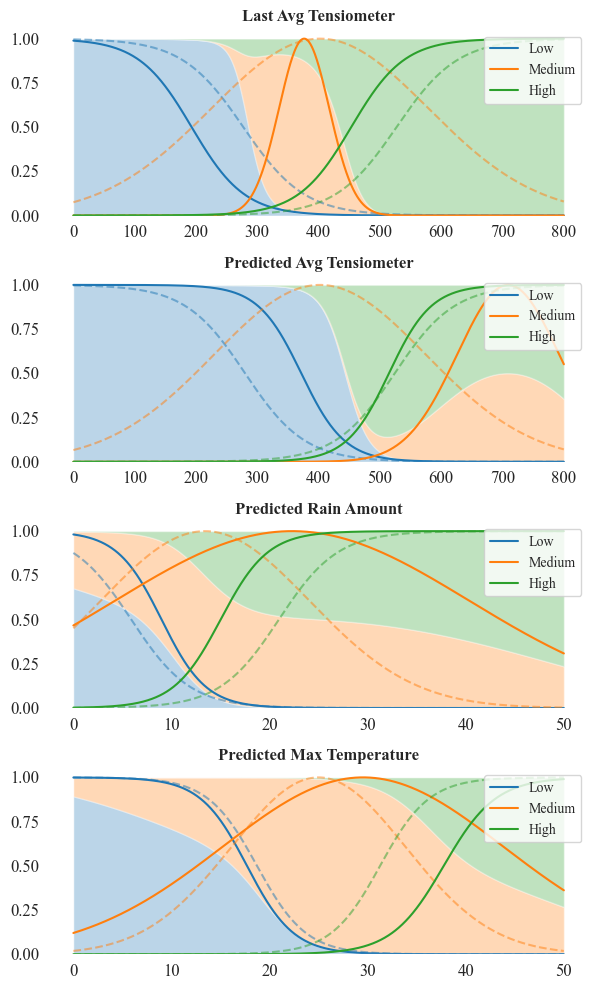

In [14]:
model.plotmfs(
    bounds=[(0,800), (0,800), (0,50), (0,50)],
    names=['Last Avg Tensiometer', 'Predicted Avg Tensiometer', 'Predicted Rain Amount', 'Predicted Max Temperature'],
    show_title=False,
    save_path='membership_functions.png')

In [39]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=SEED)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.float32)

torch.manual_seed(SEED)

model = SANFIS(membfuncs=best_membfuncs, n_input=4, scale='Std')
loss_function = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(params=model.parameters(), lr=best_lr)

history = model.fit(train_data=[X_train_tensor, y_train_tensor],
                    valid_data=[X_valid_tensor, y_valid_tensor],
                    optimizer=optimizer,
                    loss_function=loss_function,
                    epochs=best_epochs)

Train s-anfis on 284 samples, validate on 71 samples


Training Loop: 100%|##########| 200.0/200 [00:10<00:00, 18.97epochs/s, train_loss=0.0718, valid_loss=0.0871]


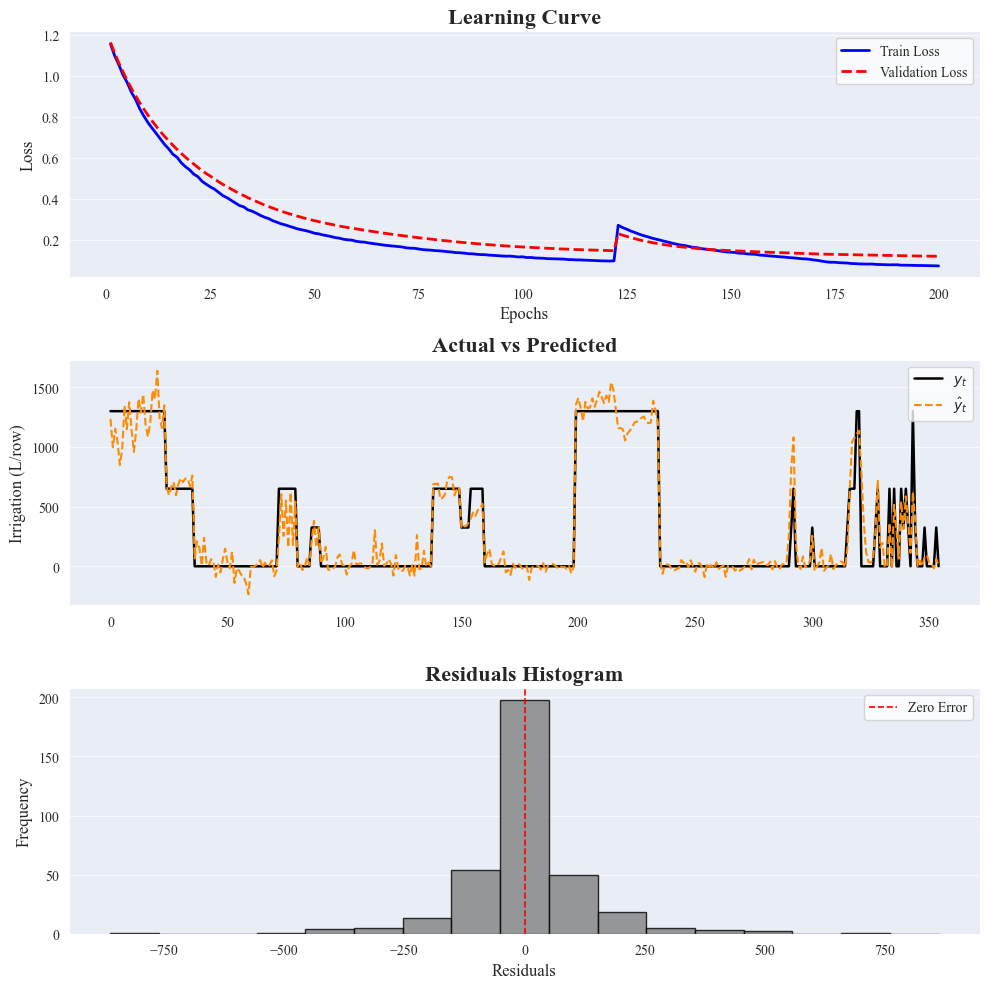

In [43]:
y = np.array(y)
y_pred = model.predict(X_tensor).numpy()

plot_train_analysis(best_result, y, y_pred, 'sanfis_train_analysis.png')

In [23]:
best_result

{'membfuncs': [{'function': 'hybrid',
   'n_memb': 3,
   'params': {'low': {'c': {'value': [-0.5], 'trainable': True},
     'gamma': {'value': [-5.0], 'trainable': True}},
    'center': {'mu': {'value': [0.0], 'trainable': True},
     'sigma': {'value': [1.0], 'trainable': True}},
    'high': {'c': {'value': [0.5], 'trainable': True},
     'gamma': {'value': [5.0], 'trainable': True}}}},
  {'function': 'hybrid',
   'n_memb': 3,
   'params': {'low': {'c': {'value': [-0.5], 'trainable': True},
     'gamma': {'value': [-5.0], 'trainable': True}},
    'center': {'mu': {'value': [0.0], 'trainable': True},
     'sigma': {'value': [1.0], 'trainable': True}},
    'high': {'c': {'value': [0.5], 'trainable': True},
     'gamma': {'value': [5.0], 'trainable': True}}}},
  {'function': 'hybrid',
   'n_memb': 3,
   'params': {'low': {'c': {'value': [-0.5], 'trainable': True},
     'gamma': {'value': [-5.0], 'trainable': True}},
    'center': {'mu': {'value': [0.0], 'trainable': True},
     'sigma': 

In [25]:
history

,train_curve,valid_curve
epoch,,
0,1.175585,1.575592
1,1.106055,1.508269
2,1.052656,1.449211
3,1.014591,1.393567
4,0.973889,1.339368
...,...,...
195,0.071456,0.087525
196,0.072218,0.087293
197,0.071052,0.087294


In [26]:
results_list

[{'membfuncs': [{'function': 'hybrid',
    'n_memb': 3,
    'params': {'low': {'c': {'value': [-0.5], 'trainable': True},
      'gamma': {'value': [-5.0], 'trainable': True}},
     'center': {'mu': {'value': [0.0], 'trainable': True},
      'sigma': {'value': [1.0], 'trainable': True}},
     'high': {'c': {'value': [0.5], 'trainable': True},
      'gamma': {'value': [5.0], 'trainable': True}}}},
   {'function': 'hybrid',
    'n_memb': 3,
    'params': {'low': {'c': {'value': [-0.5], 'trainable': True},
      'gamma': {'value': [-5.0], 'trainable': True}},
     'center': {'mu': {'value': [0.0], 'trainable': True},
      'sigma': {'value': [1.0], 'trainable': True}},
     'high': {'c': {'value': [0.5], 'trainable': True},
      'gamma': {'value': [5.0], 'trainable': True}}}},
   {'function': 'hybrid',
    'n_memb': 3,
    'params': {'low': {'c': {'value': [-0.5], 'trainable': True},
      'gamma': {'value': [-5.0], 'trainable': True}},
     'center': {'mu': {'value': [0.0], 'trainable': 